In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Reads Input Data
df_train = pd.read_csv('../input/spaceship-titanic/train.csv')
df_test = pd.read_csv('../input/spaceship-titanic/test.csv')
df_sample = pd.read_csv('../input/spaceship-titanic/sample_submission.csv')

# TODO

Just search for the tags:   
> TODO:
>
> FIXME: 


# Notebook Parameters

In [3]:
# this is the height of the seaborn plots in the notebook
base_height=10

# Light Data Exploration

Just seeing what columns are what (i.e. cat or num columns)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

In [5]:
# df_ex = df_explore won't be used in much more than light exploration
df_ex = pd.concat([df_train, df_test])
df_ex

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN


### Ideas

 - Split up Cabin into CabinGroup and CabinZone
 - Create a family size feature 
 - maybe do children count as well


# Feature Engineering

This will also be updated with the heavy data exploration section

In [6]:
# this function is used to generate a variety of features
def str_split_collect(col_series, split_by, index, debug=False):
    cabin_group_list = []
    error_count = 0
    for cabin in col_series:
        try:
            cabin_group_list.append(cabin.split(split_by)[index])
        except:
            error_count += 1
            cabin_group_list.append(np.nan)
    if (debug):
        print(f'Error Count of: {error_count}\nsplity_by={split_by}\nindex={index}')
    return cabin_group_list

In [7]:
# can add and remove features easily for trying out different methods

def feat_eng(df, drop_used_columns=False, CabinGroup=True, CabinZone=True, PassengerIdGroup=True, FamilySize=True):
    #--light feature engineering--------
    
    if CabinGroup:
        # get the cabin group of the passenger, this might be located on more dangerous places of the ship
        # gets the the first value of the cabin "B/0/P" so it would create a column with the row value "B"
        df['CabinGroup'] = str_split_collect(col_series = df['Cabin'], split_by='/', index=0, debug=False)
    
    if CabinZone:
         # get the cabin zone of the passenger, this might be located on more dangerous places of the ship
        # gets the the 3rd value of the cabin "B/0/P" so it would create a column with the row value "P"
        df['CabinZone'] = str_split_collect(col_series = df['Cabin'], split_by='/', index=2, debug=False)
        
    if drop_used_columns and CabinGroup and CabinZone:
        df = df.drop(columns=['Cabin'])
    
    if PassengerIdGroup:
        # gets the passenger group of the prassenger to be used for family size count
        # gets the the 1st value of the PassengerId "9280_02" so it would create a column with the row value "9280"
        df['PassengerIdGroup'] = str_split_collect(col_series = df['PassengerId'], split_by='_', index=0, debug=False)
    
    if FamilySize:
        # finds the family size of the passenger
        # gets the the 1st value of the PassengerId "9280_02" so it would create a column with the row value "9280"
        # then does a group by to count the number of occurrances of the group
        df['PassengerIdGroup'] = str_split_collect(col_series = df['PassengerId'], split_by='_', index=0, debug=False)
        df['FamilySize'] = df.groupby(['PassengerIdGroup'], dropna=False)['PassengerIdGroup'].transform('count')
        if not PassengerIdGroup:
            df = df.drop(columns=['PassengerIdGroup'])
    
    return df

In [8]:
df_feat = feat_eng(df_train, drop_used_columns=False, PassengerIdGroup=False)
df_feat.sample(n=5)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinGroup,CabinZone,FamilySize
4809,5133_02,Earth,True,G/829/P,PSO J318.5-22,24.0,False,0.0,0.0,0.0,0.0,0.0,Hene Litthews,False,G,P,8
6131,6468_04,Mars,False,D/204/P,TRAPPIST-1e,32.0,True,1179.0,0.0,4.0,0.0,0.0,Unchal Crité,False,D,P,4
3296,3542_01,Mars,True,F/669/S,TRAPPIST-1e,31.0,False,0.0,0.0,0.0,0.0,0.0,Beres Derry,True,F,S,1
7157,7635_01,Europa,True,B/289/S,55 Cancri e,58.0,False,0.0,0.0,0.0,0.0,0.0,Caphird Aneetle,True,B,S,1
6523,6891_01,Mars,False,D/215/P,TRAPPIST-1e,27.0,False,725.0,0.0,1660.0,0.0,0.0,Treynx Casty,True,D,P,1


# Heavy Data Exploration

Using the Features created to see corrilations.

The findings might generate more features

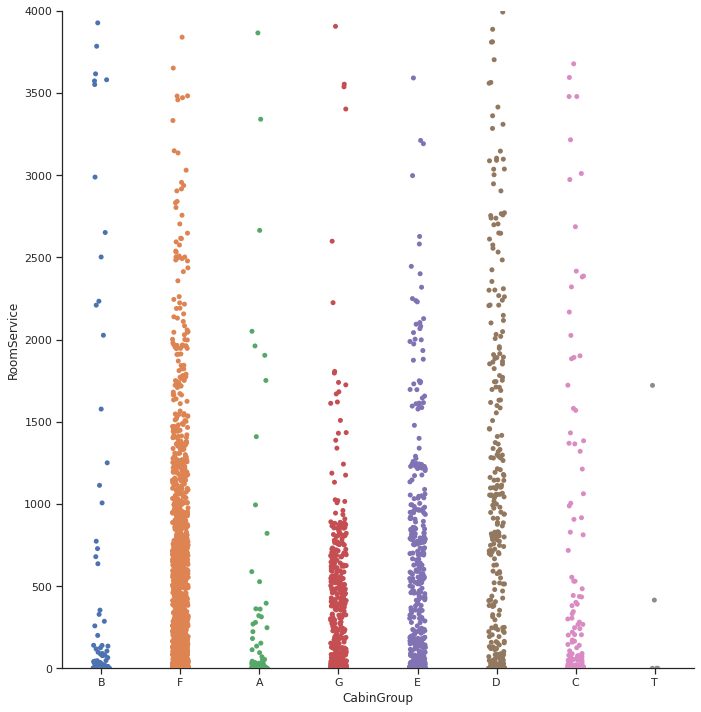

In [9]:
sns.catplot(x="CabinGroup", y="RoomService", hue=None, height=base_height, kind='strip', data=df_feat)
# control x and y limits
plt.ylim(0, 4000)
# plt.xlim(0, None)
plt.show()

In [10]:
CrosstabResult=pd.crosstab(index=(feat_eng(df_train)['CabinGroup']),columns=feat_eng(df_train)['Transported'])
CrosstabResult['TransportRate'] = (CrosstabResult.iloc[:,1]/(CrosstabResult.iloc[:,0] + CrosstabResult.iloc[:,1])).round(decimals=2)
print(CrosstabResult)

Transported  False  True  TransportRate
CabinGroup                             
A              129   127           0.50
B              207   572           0.73
C              239   508           0.68
D              271   207           0.43
E              563   313           0.36
F             1565  1229           0.44
G             1238  1321           0.52
T                4     1           0.20


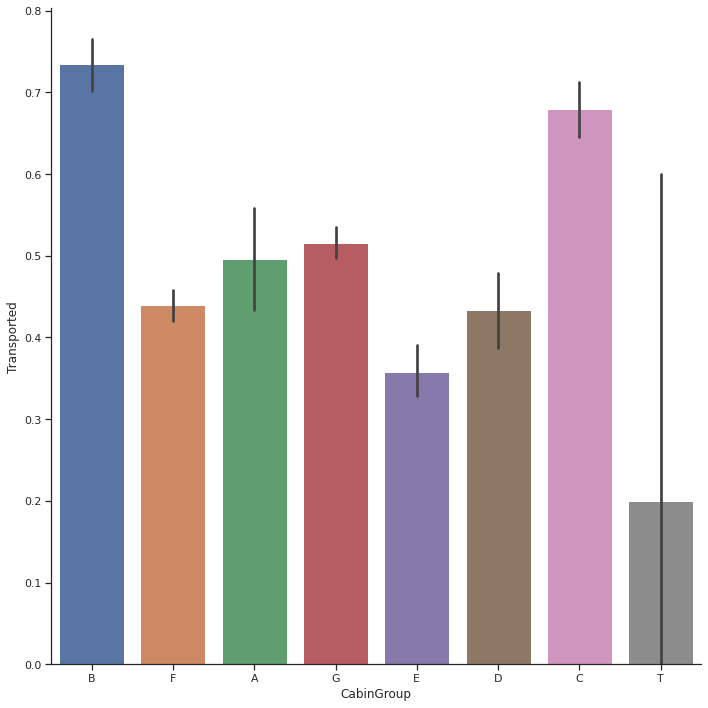

In [11]:
sns.catplot(x="CabinGroup", y="Transported", height=base_height, kind='bar', data=df_feat)

# Filling in Missing Values

In [12]:
df_feat

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,CabinGroup,CabinZone,FamilySize
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,A,P,1
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,G,S,1
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,G,S,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,E,S,2


In [13]:
# TODO: refactor the code after this line to be more applicable

# categorical_cols = ['HomePlanet', 'CryoSleep', 'CabinGroup', 'CabinZone', 'Destination', 'VIP', 'FamilySize'] # 'Name'

# # Select numerical columns
# numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

categorical_cols = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP'] # 'Name'

# Select numerical columns
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

my_cols = ['PassengerId'] + categorical_cols + numerical_cols
y = df_feat.Transported
X = df_feat[my_cols].drop(['Transported'], axis=1, errors='ignore')

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Evaluating Models

In [15]:
# evaluate the model
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def get_score(preprocessor, model):
    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                 ])
    
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(my_pipeline, X, y,
                                  cv=5,
                                  scoring='accuracy')
    return scores

In [16]:
# model picking and parameter tuning 
# TODO: update this process

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

models = []
# models.append(RandomForestClassifier(n_estimators=125, random_state=0))
# models.append(RandomForestClassifier(n_estimators=150, random_state=0))
# models.append(RandomForestClassifier(n_estimators=175, random_state=0))
models.append(RandomForestClassifier(n_estimators=95, random_state=0))
# models.append(RandomForestClassifier(n_estimators=200, random_state=0))
# models.append(RandomForestClassifier(n_estimators=225, random_state=0))
# models.append(RandomForestClassifier(n_estimators=1000, random_state=0))


# models.append(XGBClassifier(random_state=0))
# models.append(XGBClassifier(n_estimators=100, learning_rate=0.001, random_state=0))
# models.append(KNeighborsClassifier(n_neighbors=45))
# models.append(MultinomialNB())
# models.append(SVC(kernel='linear'))


for model in models:
    score = get_score(preprocessor, model)
    print(f"{model}\nAvg accuracy: {round(score.mean()*100, 2)}%\nStd of accuracy: {round(score.std()*100, 2)}%\n\n")

RandomForestClassifier(n_estimators=95, random_state=0)
Avg accuracy: 79.03%
Std of accuracy: 1.04%




In [17]:
from sklearn.model_selection import train_test_split

# Divide data into training and validation subsets
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

# Keep selected columns only
my_cols = ['PassengerId'] + categorical_cols + numerical_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

In [18]:
from sklearn.metrics import accuracy_score

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Submitting the Results

In [19]:
# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(feat_eng(df_test, drop_used_columns=False, PassengerIdGroup=False))

In [20]:
output = pd.DataFrame({'PassengerId': df_test['PassengerId'],
                       'Transported': [bool(i) for i in preds]})
output.to_csv('submission.csv', index=False)

In [21]:
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In [22]:
df_sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
